# Natural Langage Processing : Modèle de classement des textos en spam

Dans ce cas pratique, on cherche à entraîner un modèle capable de prédire si un texto est un spam ou non. On s'appuie pour cela sur une base de données contenant des sms labellisés comme spam ou non spam (trouvée sur https://archive.ics.uci.edu/ml/datasets.php, voir readme pour plus d'informations).  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA

from wordcloud import WordCloud

- Importez la base de données dans un dataframe 

In [2]:
df = pd.read_csv('smsspamcollection/SMSSpamCollection.txt', sep='\t',
                  header=None, names=['y', 'sms'])
df

,y,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


- Appliquez les transformations usuelles du texte pour faciliter l'analyse textuelle

In [3]:
# créons une fonction pour le preprocessing
def nettoyage(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", " ", text)
    text_wo_digits = re.sub('\d', '', text)
    return text, text_wo_digits

df['sms_digits'] = df.sms.apply(lambda x: nettoyage(x)[0])
df['sms_wo_digits'] = df.sms.apply(lambda x: nettoyage(x)[1])
df

,y,sms,sms_digits,sms_wo_digits
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only ...,go until jurong point crazy available only ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives aro...,nah i don t think he goes to usf he lives aro...
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,this is the nd time we have tried contact u ...
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home,will ü b going to esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",pity was in mood for that so any other s...,pity was in mood for that so any other s...
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i d...,the guy did some bitching but i acted like i d...


- Faites une matrice de termes et affichez les termes les plus fréquents dans chaque catégorie : spam ou non spam. Si nécessaire, enrichissez la liste de stop-words pour limiter la taille de la matrice.

In [4]:
cv = CountVectorizer(stop_words='english')
dtm = cv.fit_transform(df.sms_digits)
dtm_df = pd.DataFrame(dtm.toarray(),
                      columns=cv.get_feature_names_out(),
                      index=df.y)
dtm_df

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,ú1,〨ud
y,,,,,,,,,,,,,,,,,,,,,
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
spam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Beaucoup de colonnes, on va voir ce qu'on peut enelever
sum_mots = dtm_df.groupby('y').sum()
sum_mots = sum_mots.transpose()
sum_mots

y,ham,spam
00,0,10
000,0,29
000pes,1,0
008704050406,0,2
0089,0,1
...,...,...
zouk,0,1
zyada,1,0
èn,1,0
ú1,0,1


In [6]:
# On peut supprimer quand le nombre d'occurences représente moins de 1% des observations
part_occur = pd.DataFrame()
for i in ['ham','spam']:
    part_occur[i] = sum_mots[i]/len(dtm_df[dtm_df.index==i])

part_occur

,ham,spam
00,0.000000,0.013387
000,0.000000,0.038822
000pes,0.000207,0.000000
008704050406,0.000000,0.002677
0089,0.000000,0.001339
...,...,...
zouk,0.000000,0.001339
zyada,0.000207,0.000000
èn,0.000207,0.000000
ú1,0.000000,0.001339


In [7]:
# tri selon les parts d'occurences dans les 'ham'
part_occur.sort_values('ham', ascending=False).head(30)

,ham,spam
gt,0.065907,0.000000
lt,0.065492,0.000000
just,0.061554,0.105756
ok,0.059689,0.006693
ll,0.055130,0.005355
ur,0.051192,0.192771
know,0.049119,0.033467
good,0.048705,0.016064
like,0.048497,0.017403
got,0.048290,0.009371


In [8]:
# tri selon les parts d'occurences dans les 'ham'
part_occur.sort_values('spam', ascending=False).head(30)

,ham,spam
free,0.012435,0.299866
txt,0.002902,0.218206
ur,0.051192,0.192771
mobile,0.003109,0.170013
text,0.014093,0.167336
stop,0.007668,0.164659
claim,0.000000,0.151272
reply,0.009119,0.139224
www,0.000415,0.131191
prize,0.000000,0.124498


In [9]:
# on récupère la part max entre les ham et les spam
part_occur_max = part_occur.max(axis=1)
part_occur_max

00              0.013387
000             0.038822
000pes          0.000207
008704050406    0.002677
0089            0.001339
                  ...   
zouk            0.001339
zyada           0.000207
èn              0.000207
ú1              0.001339
〨ud             0.000207
Length: 8442, dtype: float64

In [10]:
# on va ajouter les stop-words tous les mots dont la part max (entre ham et spam) est inférieur à 1%
sw_supp = part_occur_max[part_occur_max<=0.01].index
my_stop_words = ENGLISH_STOP_WORDS.union(sw_supp)
len(my_stop_words), len(ENGLISH_STOP_WORDS)

(8374, 318)

In [11]:
# on refait la matrice termes-documents avec les nouveaux stop-words
cv = CountVectorizer(stop_words=my_stop_words)
dtm = cv.fit_transform(df.sms_digits)
dtm_df = pd.DataFrame(dtm.toarray(),
                      columns=cv.get_feature_names_out(),
                      index=df.y)
dtm_df

,00,000,02,03,04,06,0800,08000839402,08000930705,0870,...,word,work,worth,www,xmas,xxx,ya,yeah,yes,yr
y,,,,,,,,,,,,,,,,,,,,,
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
spam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
sum_mots = dtm_df.groupby('y').sum()
sum_mots = sum_mots.transpose()
sum_mots

y,ham,spam
00,0,10
000,0,29
02,0,8
03,0,13
04,0,12
...,...,...
xxx,24,11
ya,57,1
yeah,86,1
yes,82,21


- Faites un nuage de mots par catégorie pour bien illustrer les différences des mots utilisés entre spam et non spam.

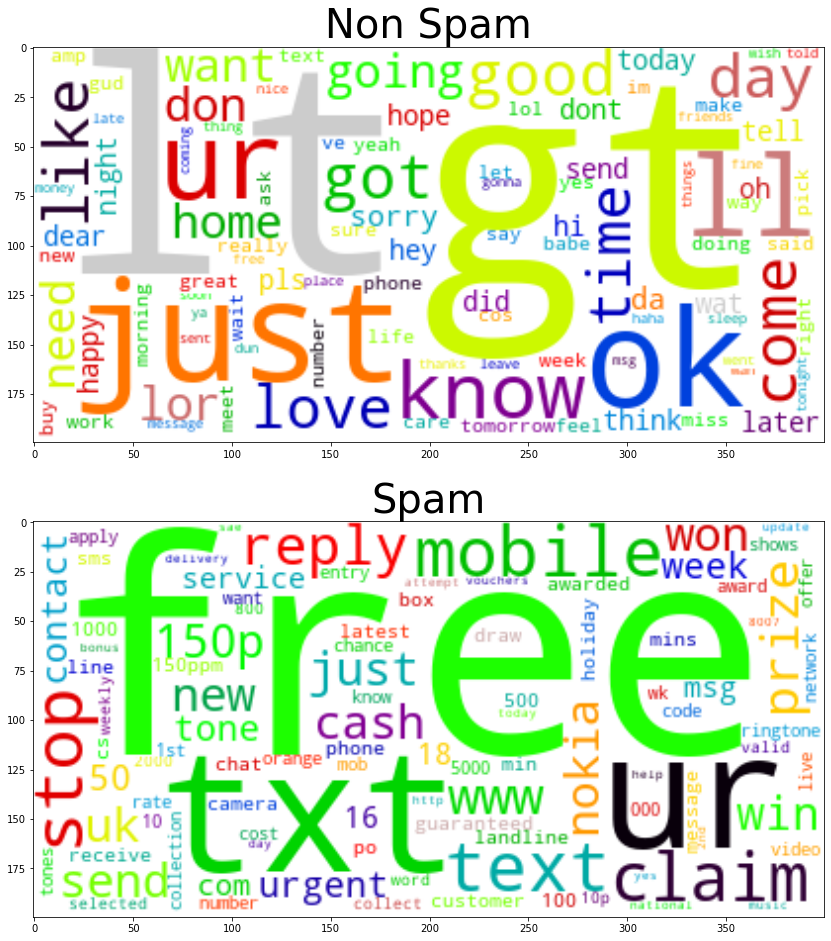

In [13]:
# on va faire un wordcloud à partir des fréquences
# on affiche les wordcloud directement depuis la matrice de fréquences des termes
wc = WordCloud(stopwords=my_stop_words,
               background_color="white", colormap="nipy_spectral",
               max_font_size=150, random_state=12,
               max_words=100)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,16))

wc.generate_from_frequencies(sum_mots['ham'])
ax1.imshow(wc, interpolation="bilinear")
ax1.set_title('Non Spam', fontdict={'size':40})

wc.generate_from_frequencies(sum_mots['spam'])
ax2.imshow(wc, interpolation="bilinear")
ax2.set_title('Spam', fontdict={'size':40});

- À partir de la matrice de termes réduite, entraînez un modèle de forêts aléatoires permettant de prédire si un texto est un spam ou non 

In [14]:
# on définit les données de test et d'entraînement
y = 1 * (dtm_df.index == 'spam')
X_train, X_test, y_train, y_test = train_test_split(dtm_df, y, test_size=0.2, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4457, 386), (1115, 386), (4457,), (1115,))

In [15]:
# on entraine la foret aléatoire et on regarde la précision
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)
print(f"Sur le train : {rf.score(X_train, y_train)}, sur le test : {rf.score(X_test, y_test)}")

Sur le train : 0.9975319721785955, sur le test : 0.9766816143497757


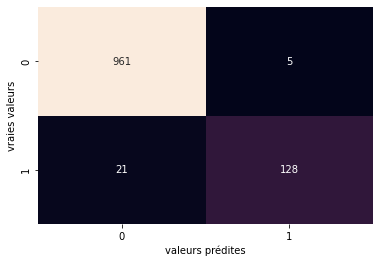

In [16]:
# on affiche la matrice de confusion
sns.heatmap(confusion_matrix(y_test, rf.predict(X_test)), annot=True, cbar=False, fmt='d')
plt.ylabel('vraies valeurs')
plt.xlabel('valeurs prédites');

- Essayez d'améliorer la prédiction de votre modèle en ajoutant une analyse en composantes principales en amont.

In [17]:
# On fait une ACP en conservant 90% de la variance expliquée
pca = PCA(0.95)
pca.fit(X_train)
pca.n_components_

211

In [18]:
# on récupère les projections sur les composantes principales
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [19]:
# on réentraine la foret aléatoire
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train_pca, y_train)
print(f"Sur le train : {rf.score(X_train_pca, y_train)}, sur le test : {rf.score(X_test_pca, y_test)}")

Sur le train : 0.9975319721785955, sur le test : 0.9766816143497757


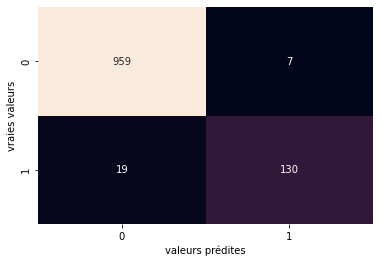

In [20]:
# on affiche la matrice de confusion
sns.heatmap(confusion_matrix(y_test, rf.predict(X_test_pca)), annot=True, cbar=False, fmt='d')
plt.ylabel('vraies valeurs')
plt.xlabel('valeurs prédites');

On peut imaginer que pour une entreprise qui développe cette solution, on souhaite plus à minimiser l'erreur consistant à définir comme spam un texto qui n'en est pas un (erreur de type 1, "faux positif") plutôt que de rater quelques spams : 
- Utilisez votre dernier modèle pour prédire des probabilités que le texto soit un spam. À partir de quelle valeur de cette probabilité notre modèle ne classe aucun non spam en spam?

In [21]:
# On va avoir besoin des probabilités prédites
pred_probas = rf.predict_proba(X_test_pca)

In [22]:
# on récupère le nombre de faux positifs (erreur de type I) sur l'échantillon test
def FP_seuil(seuil=0.5, pred_probas=pred_probas):
    y_pred = 1 * (pred_probas[:,1] > seuil)
    TFP = y_pred[y_test==0].sum()/(y_test==0).sum()
    TFN = y_pred[y_test==1].sum()/(y_test==1).sum()
    return TFP, TFN

FP_seuil(0.5)

(0.007246376811594203, 0.87248322147651)

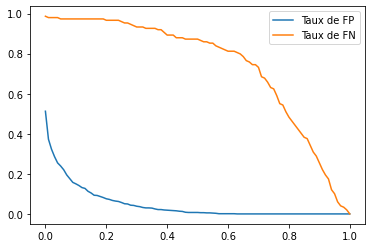

In [23]:
# on affiche l'évolution des faux positifs enn fonction du seuil de proba fixé
x = np.linspace(0,1,101)
FP_plot = list(map(lambda x: FP_seuil(x)[0], x))
FN_plot = list(map(lambda x: FP_seuil(x)[1], x))
plt.plot(x, FP_plot, label="Taux de FP")
plt.plot(x, FN_plot, label="Taux de FN")
plt.legend();

### Courbe ROC

On peut voir ce qu'on perd en précision de prédiction lorsqu'on minimise l'erreur de type 1 avec la courbe ROC (cf dans le cours sur la régression logistique le notebook sur ROC et AUC) en utilisant directement les métriques associées dans `sklearn`. Si tout va bien, on devrait obtenir le même graphique...

In [24]:
fpr0, tpr0, thresholds0 = roc_curve(y_test, pred_probas[:, 1], pos_label=rf.classes_[1], 
                                    drop_intermediate=False)

tp = pd.DataFrame(dict(taux_faux_spams=fpr0, taux_vrais_spams=tpr0, threshold=thresholds0)).copy()
tp.drop(0, axis=0, inplace=True) #suppression du 1er seuil fixé arbitrairement à 2
tp

,taux_faux_spams,taux_vrais_spams,threshold
1,0.000000,0.013423,1.000000
2,0.000000,0.020134,0.995000
3,0.000000,0.026846,0.990000
4,0.000000,0.033557,0.985000
5,0.000000,0.040268,0.980000
...,...,...,...
440,0.506211,0.986577,0.000333
441,0.508282,0.986577,0.000294
442,0.511387,0.986577,0.000278
443,0.512422,0.986577,0.000227


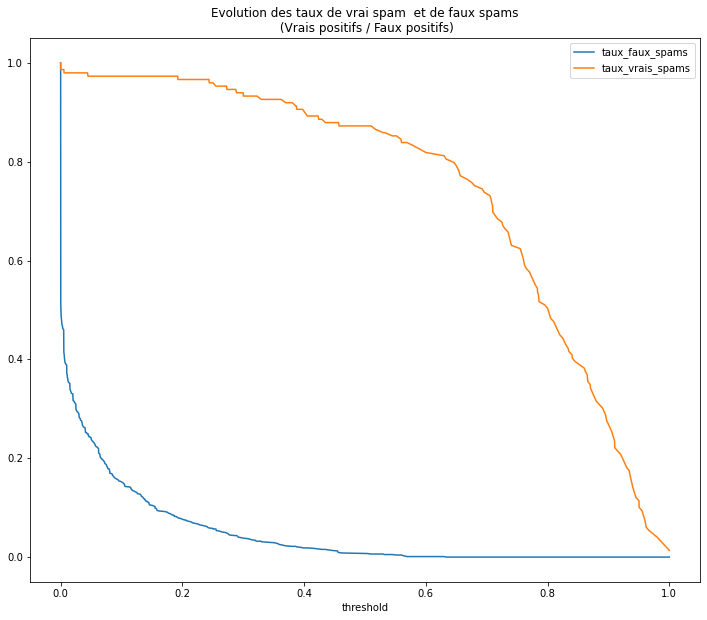

In [25]:
ax = tp.plot(x="threshold", y=['taux_faux_spams', 'taux_vrais_spams'], figsize=(12,10))
ax.set_title("Evolution des taux de vrai spam  et de faux spams\n (Vrais positifs / Faux positifs)");